# Preprocessing MFI data (all donors): SC and SN RNA-seq

11.2021

This is a preprocessing notebook, so this happens here:

Step-by-step workflow:

- load data out of Cell Ranger
- filter genes, cells, add metadata
- perform **step 1** of calling doublets using Krzysztof's bertie doublet caller:
    - see bertie_doublet_caller.ipynb in /home/jovyan/ and read comments
- concatenate all samples' data
- add doublet scores from saved tables (bertie)
- filter MT-high cells
- make cells (obs) and var (genes) unique
- save preprocessed object

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import glob
import anndata
import bbknn
import scrublet as scr
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
annoy               NA
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
bbknn               NA
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyte

In [4]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202111_MFI_sc_sn_new_scVI_analysis/'

A Benjamini-Hochberg function for later. Running FDR is surprisingly inconvenient using built-in Python options.

In [5]:
def bh(pvalues):
    '''
    Computes the Benjamini-Hochberg FDR correction.
    
    Input:
        * pvals - vector of p-values to correct
    '''
    n = int(pvalues.shape[0])
    new_pvalues = np.empty(n)
    values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]
    values.sort()
    values.reverse()
    new_values = []
    for i, vals in enumerate(values):
        rank = n - i
        pvalue, index = vals
        new_values.append((n/rank) * pvalue)
    for i in range(0, int(n)-1):
        if new_values[i] < new_values[i+1]:
            new_values[i+1] = new_values[i]
    for i, vals in enumerate(values):
        pvalue, index = vals
        new_pvalues[index] = new_values[i]
    return new_pvalues

In [6]:
###################
# doublet calling #
###################

def bertie(adata_sample, sample):
    
    scorenames = ['scrublet_score','scrublet_cluster_score','bh_pval']
    
    adata_sample_copy = adata_sample.copy()
    # set up and run Scrublet
    scrub = scr.Scrublet(adata_sample_copy.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)
    adata_sample_copy.obs['scrublet_score'] = doublet_scores
    
    # overcluster prep. run turbo basic scanpy pipeline
    sc.pp.normalize_per_cell(adata_sample_copy, counts_per_cell_after=1e4)
    sc.pp.log1p(adata_sample_copy)
    sc.pp.highly_variable_genes(adata_sample_copy, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata_sample_copy = adata_sample_copy[:, adata_sample_copy.var['highly_variable']]
    adata_sample_copy = adata_sample_copy.copy()
    sc.pp.scale(adata_sample_copy, max_value=10)
    sc.tl.pca(adata_sample_copy, svd_solver='arpack')
    sc.pp.neighbors(adata_sample_copy)
    
    # overclustering proper - do basic clustering first, then cluster each cluster
    sc.tl.louvain(adata_sample_copy)
    for clus in np.unique(adata_sample_copy.obs['louvain']):
        sc.tl.louvain(adata_sample_copy, restrict_to=('louvain',[clus]))
        adata_sample_copy.obs['louvain'] = adata_sample_copy.obs['louvain_R']
        
    # compute the cluster scores - the median of Scrublet scores per overclustered cluster
    for clus in np.unique(adata_sample_copy.obs['louvain']):
        adata_sample_copy.obs.loc[adata_sample_copy.obs['louvain']==clus, 'scrublet_cluster_score'] = \
            np.median(adata_sample_copy.obs.loc[adata_sample_copy.obs['louvain']==clus, 'scrublet_score'])
        
    # now compute doublet p-values. figure out the median and mad (from above-median values) for the distribution
    med = np.median(adata_sample_copy.obs['scrublet_cluster_score'])
    mask = adata_sample_copy.obs['scrublet_cluster_score']>med
    mad = np.median(adata_sample_copy.obs['scrublet_cluster_score'][mask]-med)
    
    #let's do a one-sided test. the Bertie write-up does not address this but it makes sense
    pvals = 1-scipy.stats.norm.cdf(adata_sample_copy.obs['scrublet_cluster_score'], loc=med, scale=1.4826*mad)
    adata_sample_copy.obs['bh_pval'] = bh(pvals)
    
    # getting calculated values to the initial object with raw count values
    for col in scorenames:
        adata_sample.obs[col] = adata_sample_copy.obs[col]
    
    return adata_sample.obs[scorenames]

### Reading and preprocessing

In [7]:
# the sample IDs are separated into groups according to their location

samples_P13_sn = ['WSSS_PLA8764121','WSSS_PLA8764122'] # /nfs/team292/aa22/202007_snRNA-seq_MFI/202005_snRNA-seq_cellranger/snRNA_seq_data_MFI_blocks_from_prof_Moffett/

samples_P13_sn_paired_Visium = ['WSSS_PLA8810750','WSSS_PLA8810751'] # /nfs/team292/aa22/202007_snRNA-seq_MFI/202006_snRNA-seq_MFI_paired_to_Visium_cellranger/ 

samples_P13_sn_new = ['Pla_Camb10691970','Pla_Camb10691971'] # /lustre/scratch117/cellgen/team292/aa22/data/sc_sn_RNA-seq_MFI_samples_202109/

samples_P13_multiome = ['Pla_Camb10714919','Pla_Camb10714920'] # /lustre/scratch117/cellgen/team292/aa22/data/202107_multiome_MFI/


samples_P14_sn_paired_Visium = ['WSSS_PLA8811068','WSSS_PLA8811069','WSSS_PLA8811070'] # /nfs/team292/aa22/202007_snRNA-seq_MFI/202006_snRNA-seq_MFI_paired_to_Visium_cellranger/

samples_P14_sn_new = ['Pla_Camb10691972'] # /lustre/scratch117/cellgen/team292/aa22/data/sc_sn_RNA-seq_MFI_samples_202109/

samples_P14_multiome = ['Pla_Camb10714918'] # /lustre/scratch117/cellgen/team292/aa22/data/202107_multiome_MFI/

samples_Hrv43_sn = ['Pla_HDBR10701666'] # /lustre/scratch117/cellgen/team292/aa22/data/sc_sn_RNA-seq_MFI_samples_202109

samples_Hrv43_multiome = ['Pla_HDBR10142863','Pla_HDBR10142864','Pla_HDBR10142865'] # /lustre/scratch117/cellgen/team292/aa22/data/202107_multiome_MFI/

samples_P34_sn = ['Pla_Camb10691975'] # /lustre/scratch117/cellgen/team292/aa22/data/sc_sn_RNA-seq_MFI_samples_202109/

samples_Vento_sc = ['FCA7167219', 'FCA7167221', 'FCA7167222', 'FCA7167223',
       'FCA7167224', 'FCA7167226', 'FCA7167230', 'FCA7167231',
       'FCA7167232', 'FCA7196218', 'FCA7196219', 'FCA7196220',
       'FCA7196224', 'FCA7196225', 'FCA7196226', 'FCA7196229',
       'FCA7196231', 'FCA7474062', 'FCA7474063', 'FCA7474064',
       'FCA7474065', 'FCA7474066', 'FCA7474068', 'FCA7474069',
       'FCA7511881', 'FCA7511882', 'FCA7511883', 'FCA7511884',
       'FCA7511885', 'FCA7511886'] # /nfs/team292/aa22/202006_scRNA-seq_MFI_cellranger/scRNA_seq_Roser_cellranger

# samples from Regina and Elias
samples_MFI_new_sc_batch_1 = ['Pla_HDBR8624430', 'Pla_HDBR8624431',
                      'Pla_HDBR8768477', 'Pla_HDBR8715512', 'Pla_HDBR8715514'] # 
samples_MFI_new_sc_batch_2 = ['Pla_HDBR10917730', 'Pla_HDBR10917731', 'Pla_HDBR10917733'] # 


samples_Hrv43_sc = ['Pla_HDBR10142767','Pla_HDBR10142768'] # /lustre/scratch117/cellgen/team292/aa22/data/scRNA-seq_MFI_new_samples_202105/
# + 1 extra sample
samples_Hrv43_sc_new = ['Pla_HDBR10701667'] # /lustre/scratch117/cellgen/team292/aa22/data/sc_sn_RNA-seq_MFI_samples_202109/

samples_Hrv46_sc = ['Pla_HDBR10142769','Pla_HDBR10142770'] # /lustre/scratch117/cellgen/team292/aa22/data/scRNA-seq_MFI_new_samples_202105/
# + 1 extra sample
samples_Hrv46_sc_new = ['Pla_HDBR10701668'] # /lustre/scratch117/cellgen/team292/aa22/data/sc_sn_RNA-seq_MFI_samples_202109/


In [8]:
# reading table with metadata
meta_table = pd.read_csv('./MFI_sc_meta_all_202111.csv')
meta_table.set_index('sample', inplace=True, drop=False)

# saving run appropriately
#meta_table['run'] = [str(int(elem)) if not np.isnan(elem) else np.nan for elem in meta_table['run']]

In [9]:
meta_table

,sample,technology,tissue,dev_age,donor,dataset,run,number_of_individuals_multiplexed,batch
sample,,,,,,,,,
FCA7167219,FCA7167219,10X_3'_scRNA-seq,decidua_immune,13_PCW,6,Vento_Nature,NaN,1,unknown
FCA7167221,FCA7167221,10X_3'_scRNA-seq,decidua_immune,11_PCW,7,Vento_Nature,NaN,1,unknown
FCA7167222,FCA7167222,10X_3'_scRNA-seq,decidua_non_immune,11_PCW,7,Vento_Nature,NaN,1,unknown
FCA7167223,FCA7167223,10X_3'_scRNA-seq,decidua_immune,13_PCW,6,Vento_Nature,NaN,1,unknown
FCA7167224,FCA7167224,10X_3'_scRNA-seq,decidua_non_immune,13_PCW,6,Vento_Nature,NaN,1,unknown
...,...,...,...,...,...,...,...,...,...
Pla_HDBR10701666,Pla_HDBR10701666,10X_3'_snRNA-seq,decidua,6_PCW,Hrv43,HDBR_new,NaN,1,unknown
Pla_Camb10691975,Pla_Camb10691975,10X_3'_snRNA-seq,decidua,12_PCW,P34,Ashley_collection_sn,NaN,1,unknown
Pla_Camb10714918,Pla_Camb10714918,10X_multiome,decidua_myometrium,8_PCW,P14,Ashley_collection_sn,NaN,1,unknown


In [10]:
samples = list(meta_table['sample'])

This is happening in the cell below:
- read the raw file (output of cellranger)
- call doublets according to bertie doublet caller and adding all the scores
- Filter: 1) cells (< 500 genes); 2) genes (< 3 cells); 
- Add %mt genes
- Add relevant annotation info

In [11]:
### %%time

holder = []

# for doublets
scorenames = ['scrublet_score','scrublet_cluster_score','bh_pval']

for sample in samples:
    print('sample', sample,
          "from samples", list(samples).index(sample)+1,
          'out of', len(samples))
    
    if sample in samples_P13_sn:
        path = '/nfs/team292/aa22/202007_snRNA-seq_MFI/202005_snRNA-seq_cellranger/snRNA_seq_data_MFI_blocks_from_prof_Moffett/'
    if sample in samples_P13_sn_paired_Visium + samples_P14_sn_paired_Visium:
        path = '/nfs/team292/aa22/202007_snRNA-seq_MFI/202006_snRNA-seq_MFI_paired_to_Visium_cellranger/'
    if sample in samples_P13_sn_new + samples_P14_sn_new + samples_Hrv43_sn + samples_P34_sn + samples_Hrv43_sc_new + samples_Hrv46_sc_new:
        path = '/lustre/scratch117/cellgen/team292/aa22/data/sc_sn_RNA-seq_MFI_samples_202109/'
    if sample in samples_P13_multiome + samples_P14_multiome + samples_Hrv43_multiome:
        path = '/lustre/scratch117/cellgen/team292/aa22/data/202107_multiome_MFI/'
    if sample in samples_Vento_sc:
        path = '/nfs/team292/aa22/202006_scRNA-seq_MFI_cellranger/scRNA_seq_Roser_cellranger/'
    if sample in samples_MFI_new_sc_batch_1 + samples_MFI_new_sc_batch_2:
        path = '/lustre/scratch117/cellgen/team292/aa22/data/scRNA-seq_MFI_from_Regina/'
    if sample in samples_Hrv43_sc + samples_Hrv46_sc:
        path = '/lustre/scratch117/cellgen/team292/aa22/data/scRNA-seq_MFI_new_samples_202105/'
        
    
    
    path_complete = glob.glob(path + 'cellranger*' + sample + '*/filtered_feature_bc_matrix.h5')[0]
    holder.append(sc.read_10x_h5(path_complete))
    
    holder[-1].var_names_make_unique()
    
    # Filer cells with less than 200 genes expressed
    sc.pp.filter_cells(holder[-1], min_genes=200)
    
    # Filer genes expressed in less than 3 cells
    sc.pp.filter_genes(holder[-1], min_cells=3)
    
    # Adding metadata
    for col in list(meta_table.columns):
        holder[-1].obs[col] = meta_table.loc[sample,col]
    
    # Sample information
    holder[-1].obs['sample'] = sample
    # In cell_id we save barcode+sample index, to be unique in the future
    holder[-1].obs['barcode_sample'] = [i+'_'+j for i,j in zip(holder[-1].obs.index, holder[-1].obs['sample'])]
    
    # Extract mitochondial genes
    mito_genes = [name for name in holder[-1].var_names if name.startswith('MT-')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    holder[-1].obs['percent_mito'] = np.sum(
        holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1
    
    #add the total counts per cell as observations-annotation to adata
    holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1 
    
    # calling doublets on current sample's adata which is holder[-1]
    print('going on to call doublets (write doublet scores into tables) with bertie')
    scores_table = bertie(holder[-1], sample)
    if list(scores_table.index) == list(holder[-1].obs.index):
        print('indices in current bertie table and sample adata are matching, assigning scores')
        for meta in scorenames:
            holder[-1].obs[meta] = scores_table[meta]
    else:
        print('indices in current bertie table and sample adata are NOT matching')

reading /nfs/team292/aa22/202006_scRNA-seq_MFI_cellranger/scRNA_seq_Roser_cellranger/cellranger302_count_FCA7167219_GRCh38-3_0_0/filtered_feature_bc_matrix.h5


sample FCA7167219 from samples 1 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 13 cells that have less than 200 genes expressed
filtered out 20388 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running 

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7167221 from samples 2 out of 62


filtered out 34 cells that have less than 200 genes expressed
filtered out 18583 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7167222 from samples 3 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 7 cells that have less than 200 genes expressed
filtered out 16150 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7167223 from samples 4 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 21 cells that have less than 200 genes expressed
filtered out 16250 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7167224 from samples 5 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 35 cells that have less than 200 genes expressed
filtered out 15435 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7167226 from samples 6 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 14802 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7167230 from samples 7 out of 62
going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 4 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running 

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7167231 from samples 8 out of 62


filtered out 20034 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running 

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7167232 from samples 9 out of 62


filtered out 19796 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running 

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7196218 from samples 10 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 7 cells that have less than 200 genes expressed
filtered out 16269 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7196219 from samples 11 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 4 cells that have less than 200 genes expressed
filtered out 15927 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7196220 from samples 12 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 73 cells that have less than 200 genes expressed
filtered out 13462 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7196224 from samples 13 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 102 cells that have less than 200 genes expressed
filtered out 15540 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7196225 from samples 14 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 42 cells that have less than 200 genes expressed
filtered out 14107 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7196226 from samples 15 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 1237 cells that have less than 200 genes expressed
filtered out 12918 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 24 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7196229 from samples 16 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 24 cells that have less than 200 genes expressed
filtered out 17375 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7196231 from samples 17 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 1 cells that have less than 200 genes expressed
filtered out 17849 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7474062 from samples 18 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 114 cells that have less than 200 genes expressed
filtered out 16774 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7474063 from samples 19 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 89 cells that have less than 200 genes expressed
filtered out 14779 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7474064 from samples 20 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 165 cells that have less than 200 genes expressed
filtered out 13283 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7474065 from samples 21 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 158 cells that have less than 200 genes expressed
filtered out 13272 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7474068 from samples 22 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 1131 cells that have less than 200 genes expressed
filtered out 14365 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7511881 from samples 23 out of 62


filtered out 3 cells that have less than 200 genes expressed
filtered out 19952 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7511882 from samples 24 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 56 cells that have less than 200 genes expressed
filtered out 15998 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7511884 from samples 25 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 294 cells that have less than 200 genes expressed
filtered out 13346 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 21 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7474066 from samples 26 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 166 cells that have less than 200 genes expressed
filtered out 14154 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7474069 from samples 27 out of 62
going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running 

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7511883 from samples 28 out of 62
going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 4 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running 

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7511885 from samples 29 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 97 cells that have less than 200 genes expressed
filtered out 14824 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample FCA7511886 from samples 30 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 399 cells that have less than 200 genes expressed
filtered out 14606 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_HDBR10142767 from samples 31 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 11495 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_HDBR10142768 from samples 32 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 18 cells that have less than 200 genes expressed
filtered out 11137 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_HDBR10142769 from samples 33 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 1 cells that have less than 200 genes expressed
filtered out 10498 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 28 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_HDBR10142770 from samples 34 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 2 cells that have less than 200 genes expressed
filtered out 11069 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 22 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_HDBR8624430 from samples 35 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 59 cells that have less than 200 genes expressed
filtered out 16381 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_HDBR8624431 from samples 36 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 303 cells that have less than 200 genes expressed
filtered out 14134 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 20 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_HDBR8768477 from samples 37 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 21 cells that have less than 200 genes expressed
filtered out 16664 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_HDBR8715512 from samples 38 out of 62
going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running 

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_HDBR8715514 from samples 39 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 79 cells that have less than 200 genes expressed
filtered out 17841 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_HDBR10917730 from samples 40 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 213 cells that have less than 200 genes expressed
filtered out 10600 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 30 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_HDBR10917731 from samples 41 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 78 cells that have less than 200 genes expressed
filtered out 10924 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 29 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_HDBR10917733 from samples 42 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:02)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 10 cells that have less than 200 genes expressed
filtered out 10541 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 26 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_HDBR10701667 from samples 43 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 12912 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_HDBR10701668 from samples 44 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 2 cells that have less than 200 genes expressed
filtered out 12396 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample WSSS_PLA8764121 from samples 45 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 8415 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 21 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample WSSS_PLA8764122 from samples 46 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 8119 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 19 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample WSSS_PLA8810750 from samples 47 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:02)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 6597 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 25 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)
running

indices in current bertie table and sample adata are matching, assigning scores
sample WSSS_PLA8810751 from samples 48 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:02)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 6824 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 23 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)
running

indices in current bertie table and sample adata are matching, assigning scores
sample WSSS_PLA8811068 from samples 49 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:02)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 6325 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 24 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)
running

indices in current bertie table and sample adata are matching, assigning scores
sample WSSS_PLA8811069 from samples 50 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:02)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 6490 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 25 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)
running

indices in current bertie table and sample adata are matching, assigning scores
sample WSSS_PLA8811070 from samples 51 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 7896 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_HDBR10142863 from samples 52 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:02)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 2 cells that have less than 200 genes expressed
filtered out 5854 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_HDBR10142864 from samples 53 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:02)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 3 cells that have less than 200 genes expressed
filtered out 6439 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_HDBR10142865 from samples 54 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:03)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 5914 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_Camb10691970 from samples 55 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 8479 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 19 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_Camb10691971 from samples 56 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 8499 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 20 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_Camb10691972 from samples 57 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 8578 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_HDBR10701666 from samples 58 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 8248 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:10)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 21 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_Camb10691975 from samples 59 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 7440 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:16)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 21 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_Camb10714918 from samples 60 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 20 cells that have less than 200 genes expressed
filtered out 6809 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_Camb10714919 from samples 61 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 4 cells that have less than 200 genes expressed
filtered out 6533 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores
sample Pla_Camb10714920 from samples 62 out of 62


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 6 cells that have less than 200 genes expressed
filtered out 6336 genes that are detected in less than 3 cells


going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running

indices in current bertie table and sample adata are matching, assigning scores


# QC, cutoff decisions and reading again

In [35]:
%%time
# concatenate all samples into 1 object
# about 3 minutes
adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


CPU times: user 5.59 s, sys: 2.41 s, total: 8 s
Wall time: 8 s


In [36]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)  

In [37]:
# median of dtected genes
np.median(adata.obs['n_genes'])

1863.0

... storing 'sample' as categorical
... storing 'technology' as categorical
... storing 'tissue' as categorical
... storing 'dev_age' as categorical
... storing 'donor' as categorical
... storing 'dataset' as categorical
... storing 'feature_types' as categorical
... storing 'genome-0' as categorical
... storing 'genome-1' as categorical
... storing 'genome-10' as categorical
... storing 'genome-11' as categorical
... storing 'genome-12' as categorical
... storing 'genome-13' as categorical
... storing 'genome-14' as categorical
... storing 'genome-15' as categorical
... storing 'genome-16' as categorical
... storing 'genome-17' as categorical
... storing 'genome-18' as categorical
... storing 'genome-19' as categorical
... storing 'genome-2' as categorical
... storing 'genome-20' as categorical
... storing 'genome-21' as categorical
... storing 'genome-22' as categorical
... storing 'genome-23' as categorical
... storing 'genome-24' as categorical
... storing 'genome-25' as categorica

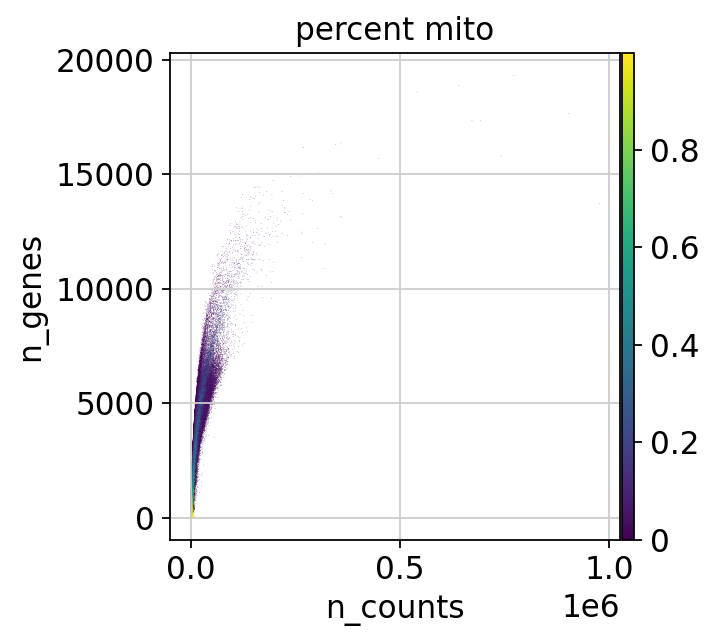

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


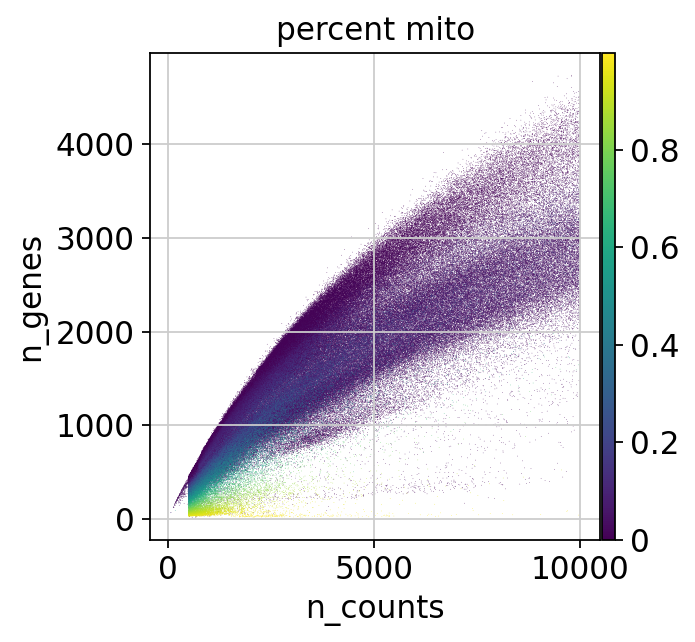

In [38]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='percent_mito')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='percent_mito')


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


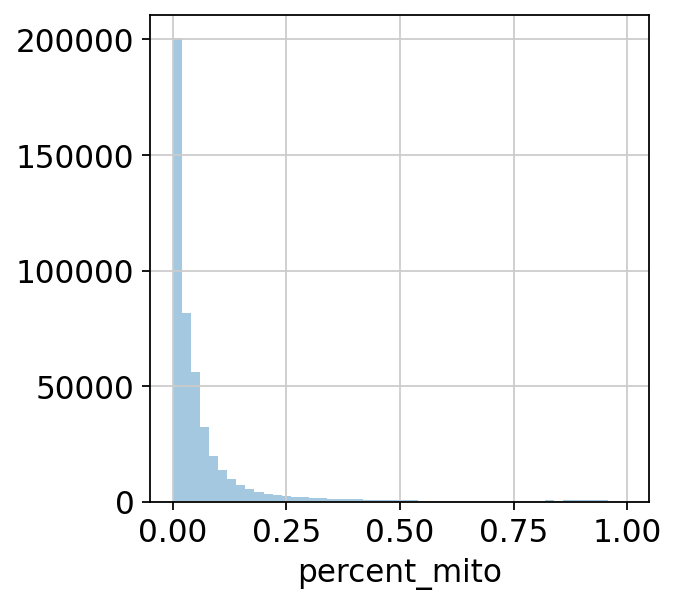

In [39]:
p3 = sns.distplot(adata.obs['percent_mito'], kde=False)
plt.show()

In [40]:
np.percentile(list(adata.obs['percent_mito']),20)

0.002918309718370439

In [41]:
len(adata[adata.obs['percent_mito'] > 0.2])

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


33013

In [42]:
len(adata[adata.obs['percent_mito'] > 0.2])/len(adata.obs)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


0.07124513349965039

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


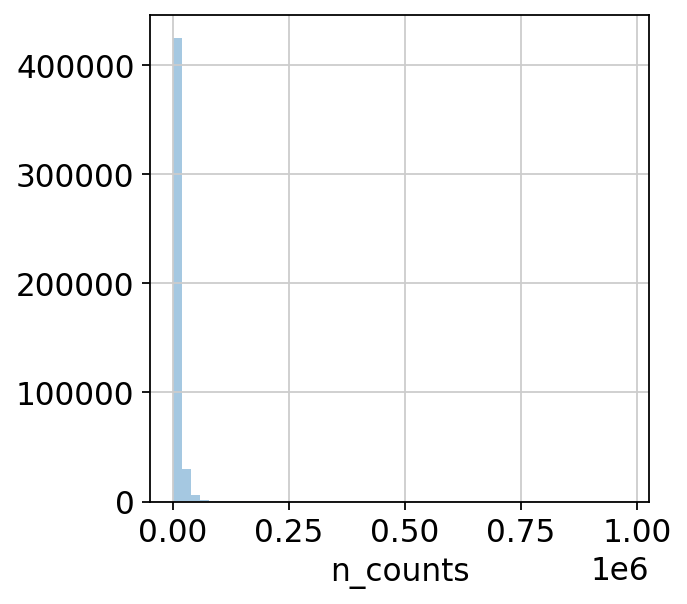

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


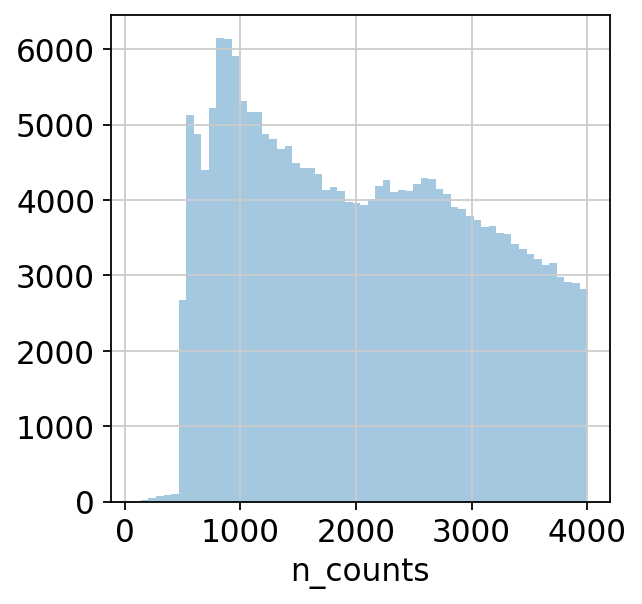

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


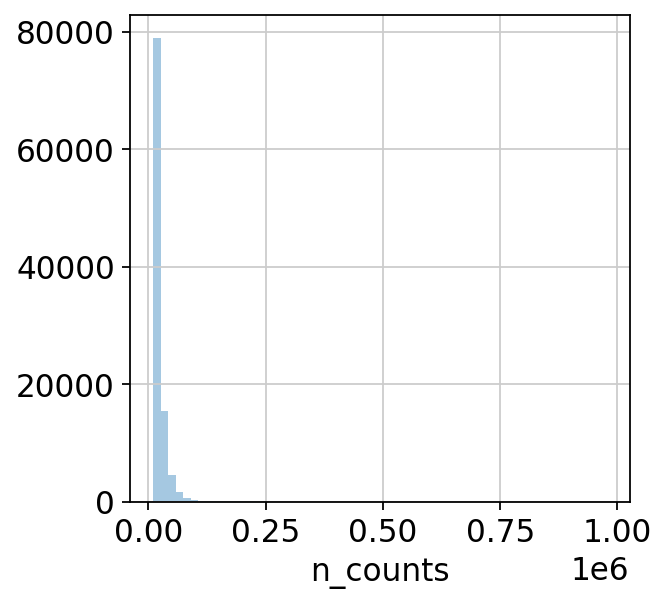

In [43]:
# Thresholding decision: counts
p3 = sns.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
plt.show()


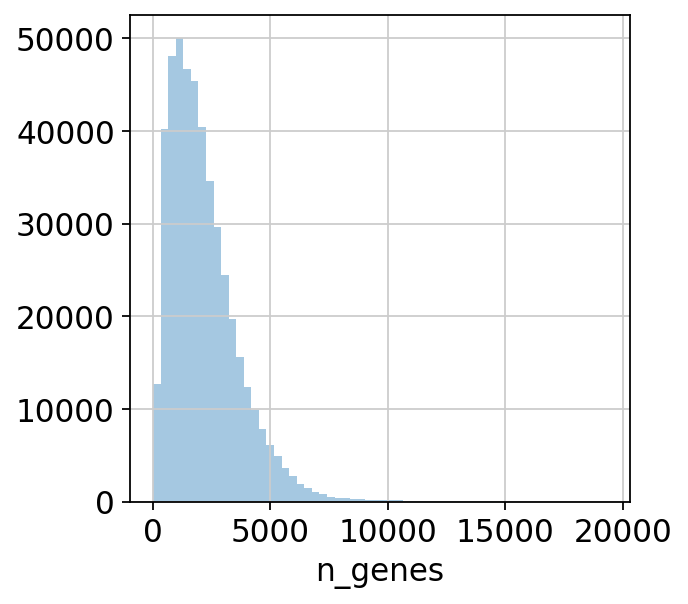

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


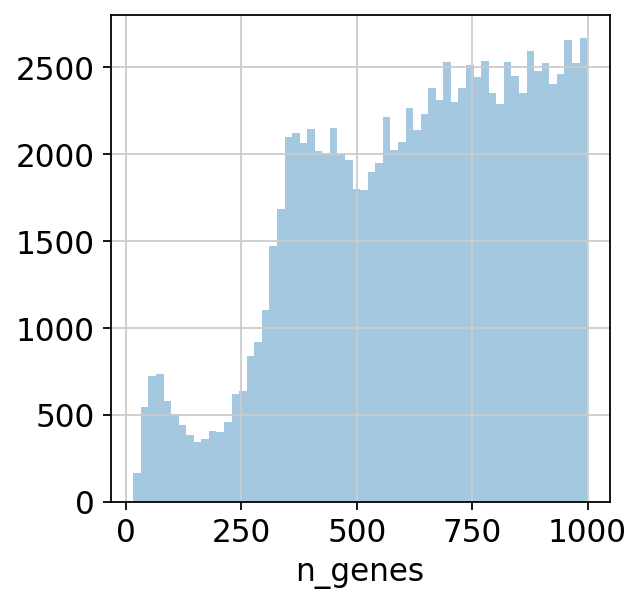

In [44]:
# Thresholding decision: genes
p6 = sns.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

**Desicion**: gene cutoff: min_genes=200, min_cells=3, going back up to reread and filter there

In [45]:
# quick check to see if raw is raw or not
expr_mtx_dense = adata[adata.obs['sample'] == 'WSSS_PLA8764121'].X.todense()

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [46]:
# YAS we all good
np.unique(expr_mtx_dense)

matrix([[   0.,    0.,    0., ..., 3341., 4238., 9029.]], dtype=float32)

____________________________________________________________________________________________________________

Carrying on to:
- Concatenate

In [12]:
%%time

adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)
adata.X = adata.X.tocsr()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


CPU times: user 27 s, sys: 4.09 s, total: 31.1 s
Wall time: 31.1 s


Carrying on to 
- Filter MT-high cells (>20%)
- Save raw attribute
- Make cell names (obs) and gene names (var) unique

In [13]:
# mt % filtering
adata = adata[adata.obs['percent_mito'] < 0.2]

# saving the raw attribute
adata.raw = adata.copy()

adata.var_names_make_unique()
adata.obs_names_make_unique()

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [14]:
# adding 'is_doublet' annotation by throsholding the bh_pvalue, this is not the end of doublet calling
# this parameter can be tweaked according to how harsh the detection needs to be
# the less it is, the less doublets it will call
adata.obs['is_doublet'] = adata.obs['bh_pval'] < 0.1

Second step of bertie doublet removal - will be done later in the pipeline (notebook M1)

_____________________________________________________________________________________________________________________________________________________________

In [15]:
adata

AnnData object with n_obs × n_vars = 430136 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'barcode_sample', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_ids-16', 'feature_types-16', 'genome-16', 'n_cells-16', 'gene_ids-17', 'feature_types-17', 'genome-17', 'n_cells-17', 'gene_ids-18', 'feature_types-18', 'genome-18', 'n_cells-18', 'gene_ids-19'

In [16]:
# setting obs index and obs names to barcode_sample column
adata.obs.set_index('barcode_sample', inplace=True)

In [17]:
expr_mtx_dense = adata[adata.obs['sample'] == 'WSSS_PLA8764121'].X.todense()

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [18]:
# YAS we good!
np.unique(expr_mtx_dense)

matrix([[   0.,    0.,    0., ..., 3341., 4238., 9029.]], dtype=float32)

In [19]:
save_path

'/lustre/scratch117/cellgen/team292/aa22/adata_objects/202111_MFI_sc_sn_new_scVI_analysis/'

In [20]:
adata.write(save_path+'adata_raw_filtered.h5ad')

... storing 'sample' as categorical
... storing 'technology' as categorical
... storing 'tissue' as categorical
... storing 'dev_age' as categorical
... storing 'donor' as categorical
... storing 'dataset' as categorical
... storing 'gene_ids-0' as categorical
... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical
... storing 'gene_ids-1' as categorical
... storing 'feature_types-1' as categorical
... storing 'genome-1' as categorical
... storing 'gene_ids-10' as categorical
... storing 'feature_types-10' as categorical
... storing 'genome-10' as categorical
... storing 'gene_ids-11' as categorical
... storing 'feature_types-11' as categorical
... storing 'genome-11' as categorical
... storing 'gene_ids-12' as categorical
... storing 'feature_types-12' as categorical
... storing 'genome-12' as categorical
... storing 'gene_ids-13' as categorical
... storing 'feature_types-13' as categorical
... storing 'genome-13' as categorical
... storing 'gene_ids-14' as 